# Installation of Packages

In [1]:
# !pip install -q tensorflow_datasets
# !pip install -q datasets
# !pip install -q keras_cv
# !pip install -q keras_hub
# !pip install -q datasets

# Download Dataset from external source

# Importing packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import  metrics
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras import callbacks
from tensorflow.keras import ops
from tensorflow.keras import regularizers
from tensorflow.keras import applications
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from datasets import load_dataset



import tensorflow_datasets as tfds

# import keras_cv
# import keras_hub

# Custom Functions

# Reading Data

In [3]:
dataset = load_dataset("Docty/Brain-Tumor-MRI")

README.md:   0%|          | 0.00/621 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/78.7M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/9.31M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2870 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/394 [00:00<?, ? examples/s]

# Data Inspection

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2870
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 394
    })
})

In [5]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=236x236>,
 'label': 0}

In [6]:
category = dataset['train'].features["label"].names
category

['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']

 # Data Visualization

In [7]:
numRows = dataset["train"].num_rows
print(numRows )

2870


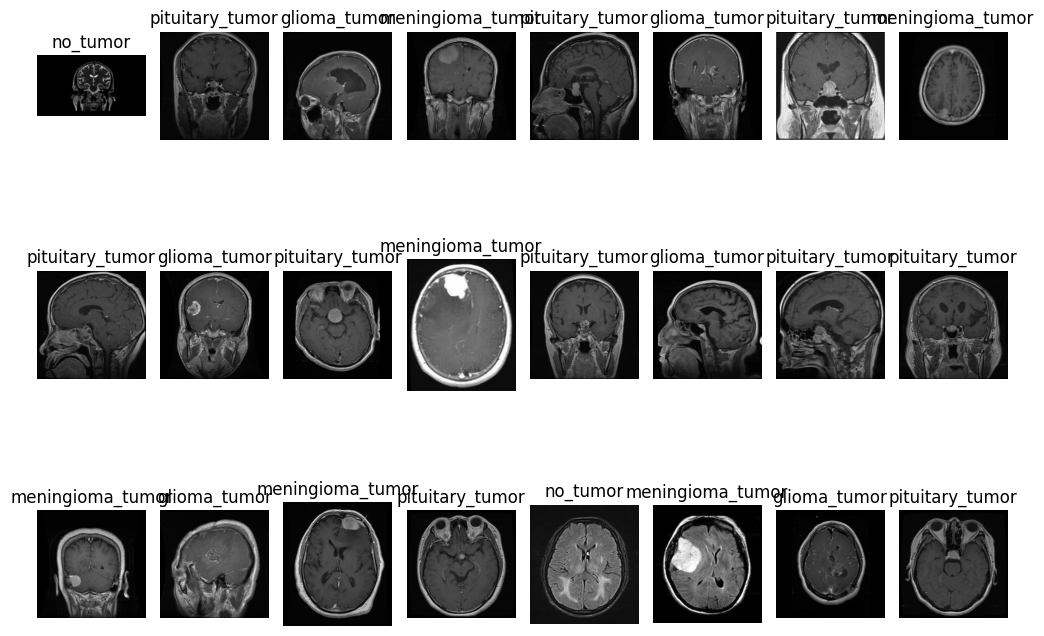

In [8]:
plt.figure(figsize=(10,8))
randomIndex = np.random.randint(0, numRows, 24)
for i in range(24):
    plt.subplot(3, 8, i+1)
    item = dataset['train'][int(randomIndex[i])]
    plt.imshow(item['image'])
    plt.title(dataset["train"].features["label"].int2str(item['label']))
    plt.axis(False)


plt.tight_layout()

# Data Preprocessing

In [9]:
# Split Data if validation data is absent
#dataset = dataset['train'].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2870
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 394
    })
})

In [10]:
IMG_SIZE = 299
BATCH_SIZE = 48
size = (IMG_SIZE, IMG_SIZE)
NUM_CLASSES = dataset['train'].features["label"].num_classes

In [11]:
train_data_augmentation = models.Sequential(
    [
        layers.RandomCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0 / 127.5, offset=-1),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="train_data_augmentation",
)

val_data_augmentation = models.Sequential(
    [
        layers.CenterCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ],
    name="val_data_augmentation",
)

In [12]:
def convert_to_tf_tensor(image):
    np_image = np.array(image)
    tf_image = tf.convert_to_tensor(np_image)

    return tf.expand_dims(tf_image, 0)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    images = [
        train_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [tf.squeeze(image) for image in images]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    images = [
        val_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [tf.squeeze(image) for image in images]
    return example_batch

In [13]:
# def preprocess_data(example):
#     image = tf.image.resize(example["image"], (size[0], size[1]))  # Resize to 64x64
#     image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
#     label = example["labels"]
#     return {"pixel_values": image, "label": label}
     

In [14]:
train_ds = dataset["train"].with_transform(preprocess_train) 

#val_ds = dataset["validation"].with_transform(preprocess_val)
#test_ds = dataset["test"].with_transform(preprocess_val)

split = dataset["validation"].train_test_split()
val_ds = split["train"].with_transform(preprocess_val)
test_ds = split["test"].with_transform(preprocess_val)

#train_ds1 = dataset["train"].map(preprocess_data)
#val_ds = dataset["validation"].with_transform(preprocess_val)
#val_ds = dataset["test"].map(preprocess_data)  

In [15]:
train_ds[0].keys()

dict_keys(['image', 'label', 'pixel_values'])

In [16]:
tf_train_dataset = train_ds.to_tf_dataset(
    columns=["pixel_values"],
    label_cols="label",
    shuffle=True,
    batch_size=BATCH_SIZE
)
 

/opt/conda/lib/python3.10/site-packages/datasets/arrow_dataset.py:403: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [17]:
tf_eval_dataset = val_ds.to_tf_dataset(
    columns=["pixel_values"],
    label_cols="label",
    shuffle=False,
    batch_size=BATCH_SIZE
)

In [18]:
tf_test_dataset = test_ds.to_tf_dataset(
    columns=["pixel_values"],
    label_cols="label",
    shuffle=False,
    batch_size=BATCH_SIZE
)

# Data Postprocessing

In [19]:
tf_train_dataset,  tf_eval_dataset, tf_test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# Model

###### **Custom Model**

In [20]:
def custom_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    model =  models.Model(inputs, outputs)
    return model

###### **Pretrained Model**

In [21]:
def pretrained_model(input_shape, num_classes):
    model = applications.EfficientNetB0(
        include_top=True,
        weights=None,
        classes=num_classes,
        input_shape=input_shape,
        )
    return model

###### **Transfer Learning Model**

In [22]:
def transfer_model(input_shape, num_classes):
     
    base_model = applications.VGG16(weights='imagenet', include_top=False, 
                               input_shape=input_shape )

    # Set the layers of the base model as non- trainable (freeze them)
    for layer in base_model.layers:
        base_model.trainable = False
   

    model = models.Sequential( )
    model. add(base_model)
    # Add a fully connected layer and output layer for classification
    model.add( layers.GlobalAveragePooling2D( ) )
    model.add(layers.Dense(128, activation='relu' , kernel_regularizer=regularizers.l2(0.001) ) )
    model.add(layers.Dropout(0.4) )
    model.add(layers.Dense(64, activation='relu' , kernel_regularizer=regularizers.l2(0.001) ) )
    model.add(layers.Dropout( 0.2) )
    model.add(layers.Dense(4, activation='softmax' ) )
    
    return model

##### **Usage**

In [23]:
input_shape = (IMG_SIZE, IMG_SIZE, 3)
input_shape, NUM_CLASSES

((299, 299, 3), 4)

In [24]:
#model = custom_model(input_shape=input_shape, num_classes=NUM_CLASSES)
#model = pretrained_model(input_shape=input_shape, num_classes=NUM_CLASSES)
model = transfer_model(input_shape=input_shape, num_classes=NUM_CLASSES)

 

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
# utils.plot_model(model, show_shapes=True)
#model.summary()

# Compile

In [26]:
# model.compile(optimizer=optimizers.Adam(learning_rate=1e-2), 
#               loss=losses.SparseCategoricalCrossentropy(from_logits=True), 
#               metrics=["accuracy"])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fit

In [27]:
epochs = 50

custom_callbacks = [
    callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    callbacks.EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_accuracy' , factor=0.001, patience=10, verbose=1),
]

In [28]:
history = model.fit(tf_train_dataset, validation_data=tf_eval_dataset, 
                    epochs=epochs, callbacks=custom_callbacks)

Epoch 1/50


I0000 00:00:1732931133.539677      93 service.cc:145] XLA service 0x5ce18b989900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732931133.539743      93 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732931133.539747      93 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732931168.144983      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.3246 - loss: 1.6187 - val_accuracy: 0.3458 - val_loss: 1.4345 - learning_rate: 0.0010
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.4789 - loss: 1.3018 - val_accuracy: 0.4678 - val_loss: 1.2976 - learning_rate: 0.0010
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.6175 - loss: 1.0707 - val_accuracy: 0.4915 - val_loss: 1.2941 - learning_rate: 0.0010
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.6672 - loss: 0.9659 - val_accuracy: 0.5220 - val_loss: 1.2765 - learning_rate: 0.0010
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.6926 - loss: 0.8821 - val_accuracy: 0.5085 - val_loss: 1.2932 - learning_rate: 0.0010
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.7133 - loss: 0.8503 - val_accuracy: 0.5051 - val_loss: 1.3547 - learning_rate: 0.0010
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 4.


# Evaluation

In [41]:
# score = model.evaluate(ds_evalTF4)
# print("Test loss:", score[0])
# print("Test accuracy:", score[1])

test_loss, test_acc = model.evaluate(tf_test_dataset)
print(f"Test accuracy: {test_acc:.2f}")
print(f"Test loss: {test_loss:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 417ms/step - accuracy: 0.3231 - loss: 1.5012
Test accuracy: 0.32
Test loss: 1.52


In [30]:
true_labels = tf.concat([label[1] for label in tf_test_dataset], axis=0)
predictions = tf.argmax(model.predict(tf_test_dataset), axis=-1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 645ms/step


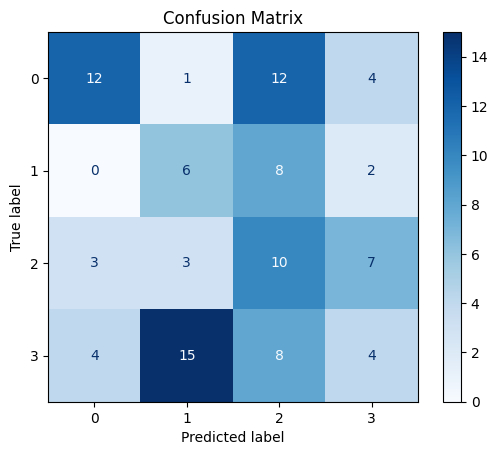

In [31]:
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(cm.shape[0]))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [32]:
def make_plot(metric):
  plt.plot(history.history[metric ])
  plt.plot(history.history['val_'+metric ])
  plt.title( 'Model '+metric )
  plt.ylabel( metric.capitalize() )
  plt.xlabel( 'Epoch' )
  plt.legend([ 'Train' , 'Validation' ], loc='upper left' )
  plt.show()

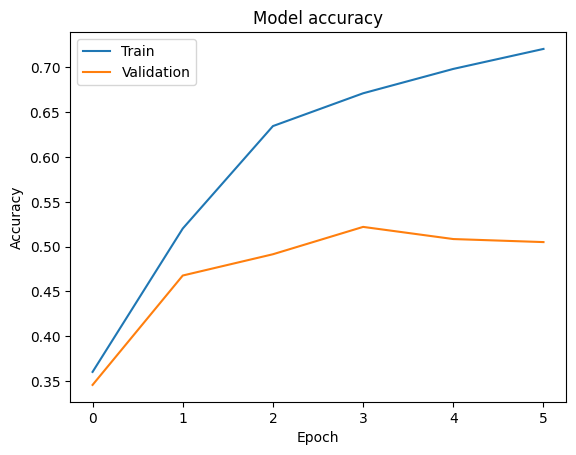

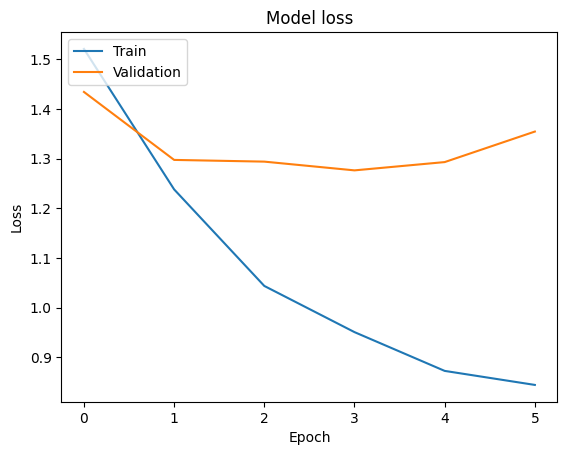

In [33]:
make_plot('accuracy')
make_plot('loss')

# Inference

In [34]:
# img = keras.utils.load_img("PetImages/Cat/6779.jpg", target_size=image_size)
# plt.imshow(img)

# img_array = keras.utils.img_to_array(img)
# img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

# predictions = model.predict(img_array)
# score = float(keras.ops.sigmoid(predictions[0][0]))
# print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

In [35]:
sample = test_ds[30]
img = img_array = ops.expand_dims(sample['pixel_values'], 0)

In [36]:
preds = model.predict(img)
preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[0.00448386, 0.8247989 , 0.1185925 , 0.05212478]], dtype=float32)

In [37]:
index = tf.argmax(preds, axis=1)
#print(index)
print('Predicted : ', category[index.numpy()[0]])
print('Actual : ', category[sample['label']])

Predicted :  pituitary_tumor
Actual :  pituitary_tumor


# Deploy

In [43]:
model.save("brain_tumor_mri.h5")

In [40]:
#del model